In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import seaborn as sns

2024-11-08 15:32:56.423301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 15:32:56.423340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 15:32:56.424758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 15:32:56.432865: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_dir = '../final_dataset2'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [3]:
#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Train,Val and Test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2412 images belonging to 3 classes.
Found 515 images belonging to 3 classes.
Found 519 images belonging to 3 classes.


In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2024-11-08 15:33:01.144544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31124 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0


In [5]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x)

In [6]:
model = Model(inputs=base_model.input, outputs=output_layer)

In [7]:
#Freeze early layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10


2024-11-08 15:33:04.911743: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
2024-11-08 15:33:07.975425: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0368e49a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-08 15:33:07.975454: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-DGXS-32GB, Compute Capability 7.0
2024-11-08 15:33:07.982661: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731079988.094356   49176 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 [==============================] - 38s 423ms/step - loss: 0.7827 - accuracy: 0.7753 - val_loss: 0.1825 - val_accuracy: 0.9282
Epoch 2/10
76/76 [==============================] - 30s 394ms/step - loss: 0.1752 - accuracy: 0.9341 - val_loss: 0.2123 - val_accuracy: 0.9049
Epoch 3/10
76/76 [==============================] - 30s 397ms/step - loss: 0.1223 - accuracy: 0.9527 - val_loss: 0.1485 - val_accuracy: 0.9437
Epoch 4/10
76/76 [==============================] - 29s 389ms/step - loss: 0.0934 - accuracy: 0.9689 - val_loss: 0.1575 - val_accuracy: 0.9243
Epoch 5/10
76/76 [==============================] - 30s 399ms/step - loss: 0.0904 - accuracy: 0.9627 - val_loss: 0.1117 - val_accuracy: 0.9573
Epoch 6/10
76/76 [==============================] - 31s 408ms/step - loss: 0.0412 - accuracy: 0.9925 - val_loss: 0.1189 - val_accuracy: 0.9495
Epoch 7/10
76/76 [==============================] - 31s 411ms/step - loss: 0.0329 - accuracy: 0.9917 - val_loss: 0.0994 - val_accuracy: 0.9650
Epoch 8/10

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

17/17 [==============================] - 7s 357ms/step - loss: 0.1174 - accuracy: 0.9557
Test accuracy: 0.9556840062141418


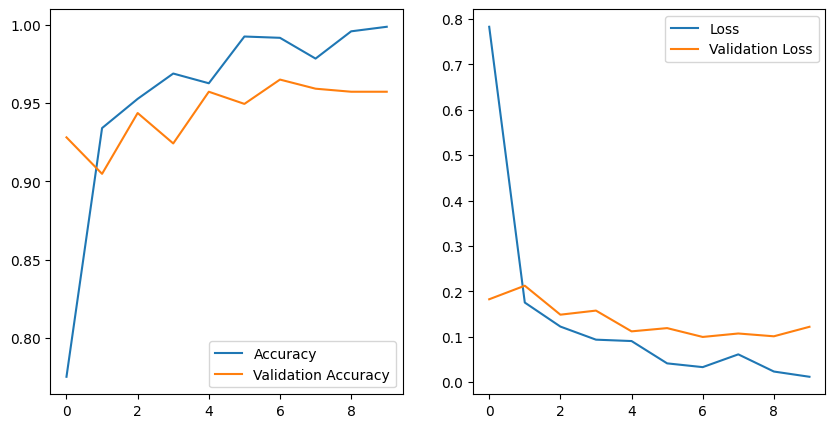

In [10]:
#Accuracy,Val accuracy, loss and val loss graphs
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [11]:
predictions = model.predict(test_generator)
class_predictions = predictions.argmax(axis=1)  # Get the class with the highest probability
# True labels from test generator
true_labels = test_generator.classes

17/17 [==============================] - 6s 301ms/step


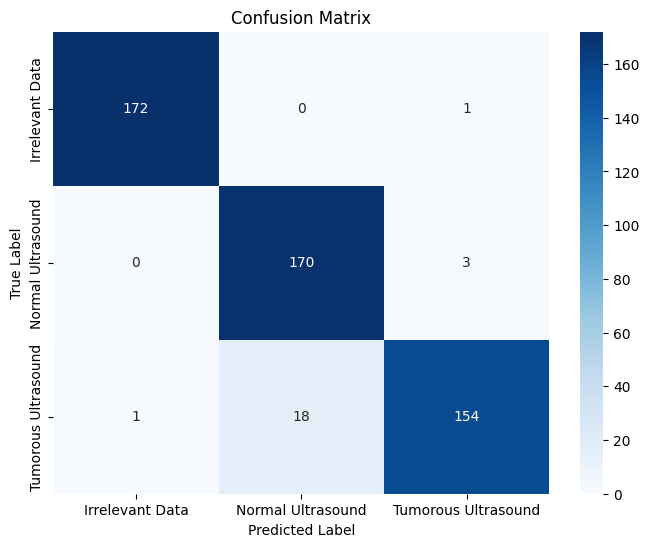

In [12]:
cm = confusion_matrix(true_labels, class_predictions)

class_labels = ['Irrelevant Data', 'Normal Ultrasound', 'Tumorous Ultrasound']

# Plot confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [13]:
from keras.preprocessing import image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224,224))  # Adjust target size as needed
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values
    return img_array

def predict_single_image(model, image_path):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)
    return prediction

In [14]:
image_path = '../Dataset_BUSI_with_GT/benign/benign (4).png'  # Replace with the actual image filename
prediction = predict_single_image(model, image_path)
prediction

1/1 [==============================] - 1s 646ms/step


array([[2.6040761e-13, 1.4305529e-07, 9.9999988e-01]], dtype=float32)